# Visualise undelayed demand for beds for admitted patients

One reason why Emergency Departments (EDs) fail to meet admissions targets is because beds are not available at the time patients arrive. Most discharges happen in the afternoon, so patients arriving at night into a full hospital often have to wait until late the following day to be admitted. UCLH wanted to understand their undelayed demand over the course of a day - that is, when beds would be needed if patients were processed within the 4-hour target time. A formal term for this (used in queueing theory) is "offered load". Here we use "undelayed demand" as it better conveys the concept to healthcare staff. UCLH wanted to understand their undelayed demand patterns to inform an improvement project focus on their emergency patient pathway.

This notebook generates charts that aim to answer the following questions: 

* What is the typical pattern of arrivals of admitted patients over the day?
* If ED/SDEC were meeting 4-hour targets for admitted patients, when would beds for these patients need to be ready?**
* Are there differences in the above between weekends and weekdays? 
* The discharge window, when decision-makers are on wards, is between 8.30 am and 5 pm. If a hospital wants to meet its ED targets on a consistent basis, then there should be enough empty beds to cover demand over night by the end of the discharge window when decision-makers leave. How many beds would need to be available at the end of discharge window to cover all demand over night? 

To answer these questions we will prepare a model using only 

* historical arrival rates of patients later admitted
* 4-hour targets for ED. We assume that the hospital might want to choose a certain percentage of admitted patients to be processed into a bed within 4 hours, accordingly to current targets. 

Here we refer to both Emergency Department (EDs) and Same Day Emergency Care (SDECs) since patients can be admitted to the hospital from both. 




## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work' 


import patientflow

In [4]:
PROJECT_ROOT

PosixPath('/Users/zellaking')

In [52]:
data_path= USER_ROOT / 'patientflow' / 'data-public'

In [53]:
# import numpy as np
# seed_path = USER_ROOT / 'seed' 
#     # Read the seed from a saved file
# with open(seed_path, 'r') as file:
#     seed = int(file.read().strip())
# # Set the seed for numpy
# np.random.seed(seed=seed)
# n = np.random.randint(1, 10*52)  


## Set file paths

In [29]:
uclh = True

In [30]:
from patientflow.load import set_file_paths
from patientflow.load import load_config_file

# set file locations
data_folder_name = 'data-uclh' if uclh else 'data-public'

# set file paths
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        train_dttm = None, data_folder_name = data_folder_name, uclh = uclh, from_notebook=True, inference_time = False)

# create subfolders for weekdays and weekends
if uclh:
    media_file_path_weekdays = media_file_path / 'undelayed-demand-uclh' / 'weekdays'
    media_file_path_weekends = media_file_path / 'undelayed-demand-uclh' / 'weekends'
    media_file_path_all_days = media_file_path / 'undelayed-demand-uclh' / 'all_days'
else:
    media_file_path_weekdays = media_file_path / 'undelayed-demand' / 'weekdays'
    media_file_path_weekends = media_file_path / 'undelayed-demand' / 'weekends'
    media_file_path_all_days = media_file_path / 'undelayed-demand' / 'all_days'
    
media_file_path_weekdays.mkdir(parents=True, exist_ok=True)
media_file_path_weekends.mkdir(parents=True, exist_ok=True)
media_file_path_all_days.mkdir(parents=True, exist_ok=True)

Configuration will be loaded from: /home/jovyan/work/patientflow/config-uclh.yaml
Data files will be loaded from: /home/jovyan/work/patientflow/data-uclh
Trained models will be saved to: /home/jovyan/work/patientflow/trained-models
Images will be saved to: /home/jovyan/work/patientflow/notebooks/img


## Load parameters

These are set in config.json. 

In [31]:
# load params from config file
params = load_config_file(config_path)

# prediction_times = params["prediction_times"]
# start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]
x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
# prediction_window = params["prediction_window"]
# epsilon = float(params["epsilon"])
# yta_time_interval = params["yta_time_interval"]

print(f'The aspiration is for {y1*100}% of patients to be admitted within {x1} hours, and {y2*100}% of patients to be admitted within {x2} hours')

The aspiration is for 78.0% of patients to be admitted within 4.0 hours, and 99.0% of patients to be admitted within 12.0 hours


## Load data

Here we load the data

In [36]:
import pandas as pd
from patientflow.load import set_data_file_names
from patientflow.load import data_from_csv

# data_file_path = Path('/home/jovyan/work/patientflow/data-raw-uclh')

if uclh:
    visits_path, visits_csv_path, yta_path, yta_csv_path = set_data_file_names(uclh, data_file_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_data_file_names(uclh, data_file_path)


inpatient_arrivals = pd.read_csv(yta_csv_path)
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'], utc = True)
inpatient_arrivals.set_index('arrival_datetime', inplace=True)


weekdays = inpatient_arrivals[inpatient_arrivals.index.weekday < 5]
weekends = inpatient_arrivals[inpatient_arrivals.index.weekday >= 5]



In [37]:
# summarise
print(f"Weekday dates span {weekdays.index.date.min()} to {weekdays.index.date.max()}")
print(f"Weekend dates span {weekends.index.date.min()} to {weekends.index.date.max()}")



Weekday dates span 2022-02-01 to 2024-02-29
Weekend dates span 2022-02-05 to 2024-02-25


Note how simple the dataset is that is used in the rest of this notebook. The only columns used are the arrival_datetime index, and (at the very end of the notebook) the specialty of admission. Similar breakdown as for specialty could be done for by sex or for adults/children, if useful.

In [38]:
inpatient_arrivals.head()

,training_validation_test,sex,specialty,is_child
arrival_datetime,,,,
2022-08-05 17:40:00+00:00,train,F,surgical,False
2022-03-17 19:51:00+00:00,train,F,haem/onc,False
2022-03-09 04:24:00+00:00,train,M,medical,False
2022-02-01 17:04:00+00:00,train,F,medical,False
2022-02-01 02:46:00+00:00,train,F,medical,False


## Get arrival rates by hour

We first plot the arrival rates for each hour of the day, at weekdays and weekends, using the historical data

In [60]:
media_file_path

PosixPath('/home/jovyan/work/zella/patientflow/notebooks/img')

Calculating time-varying arrival rates for data provided, which spans 543 unique dates


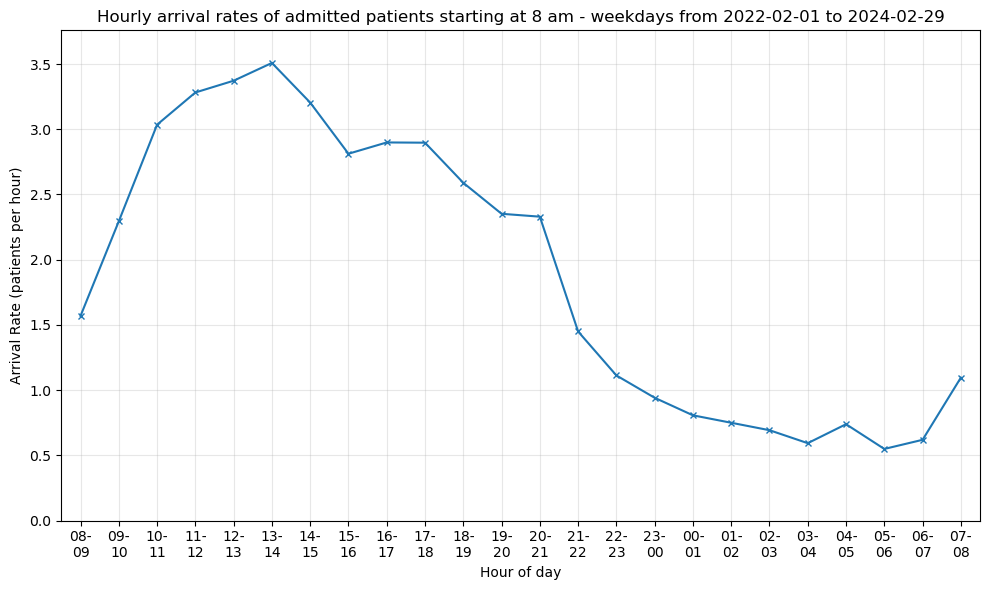

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


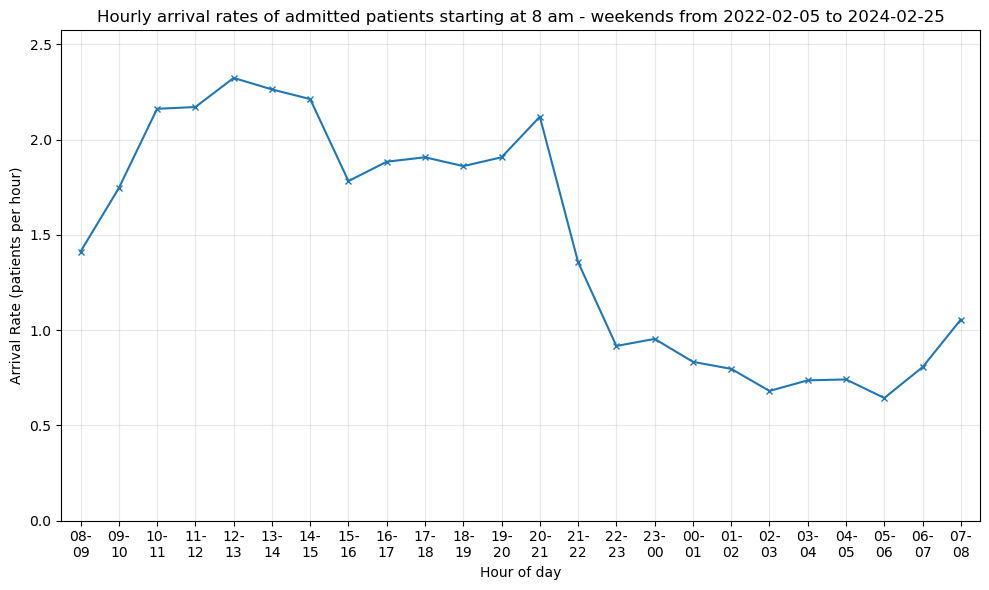

Calculating time-varying arrival rates for data provided, which spans 543 unique dates
Calculating time-varying arrival rates for data provided, which spans 216 unique dates


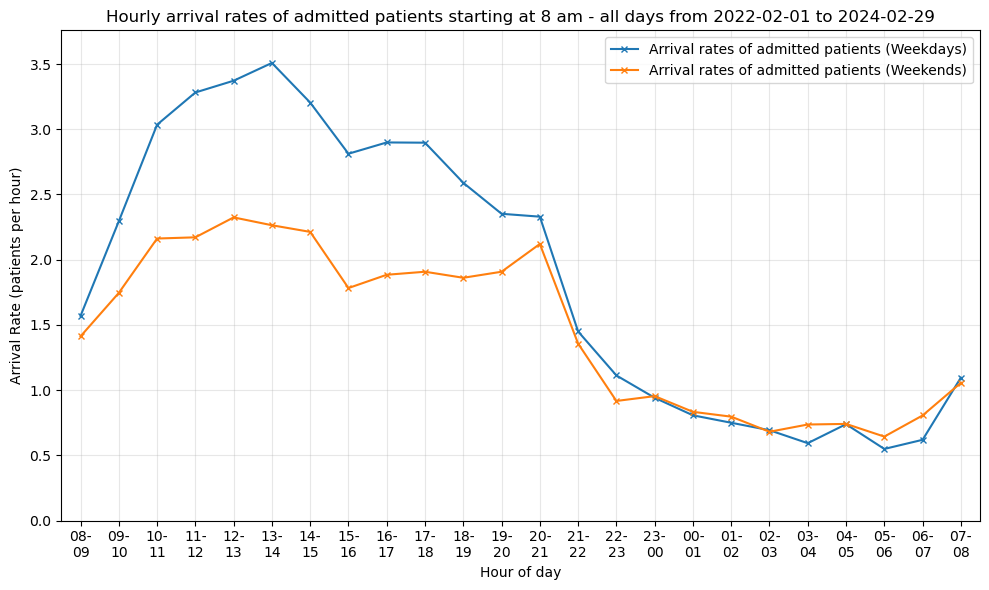

In [49]:
from patientflow.viz.arrival_rates import plot_arrival_rates
from datetime import timedelta

# Set the plot to start at the 8th hour of the day (if not set the function will default to starting at midnight
start_plot_index = 8

# plot for weekdays
title = f'Hourly arrival rates of admitted patients starting at {start_plot_index} am - weekdays from {weekdays.index.date.min()} to {weekdays.index.date.max()}'
plot_arrival_rates(weekdays, 
                   title, 
                   time_interval=60, 
                   start_plot_index=start_plot_index, 
                   file_prefix = '1_',
                   media_file_path=media_file_path_weekdays)

# plot for weekends
title = f'Hourly arrival rates of admitted patients starting at {start_plot_index} am - weekends from {weekends.index.date.min()} to {weekends.index.date.max()}'
plot_arrival_rates(weekends, 
                   title, 
                   time_interval=60, 
                   start_plot_index=start_plot_index, 
                   file_prefix = '1_',
                   media_file_path=media_file_path_weekends
                   )


# plot for both
title = f'Hourly arrival rates of admitted patients starting at {start_plot_index} am - all days from {inpatient_arrivals.index.date.min()} to {inpatient_arrivals.index.date.max()}'
plot_arrival_rates(inpatient_arrivals=weekdays,
                        inpatient_arrivals_2=weekends, 
                    labels=('Weekdays', 'Weekends'),
                   title=title, 
                   time_interval=60, 
                   start_plot_index=start_plot_index, 
                   file_prefix = '1_',
                   media_file_path=media_file_path_all_days
                   )

## Plot the time beds would be needed if each patient were admitted exactly 4 hours after arrival

We now make the assumption that the bed is needed exactly 4 hours after arrival. This assumes that every patient meets the 4-hour target, and that there is no variation in the time it takes people to be processed through ED/SDEC, so it is not realistic, but serves as a starting point. 

Calculating time-varying arrival rates for data provided, which spans 543 unique dates
Calculating time-varying arrival rates for data provided, which spans 543 unique dates


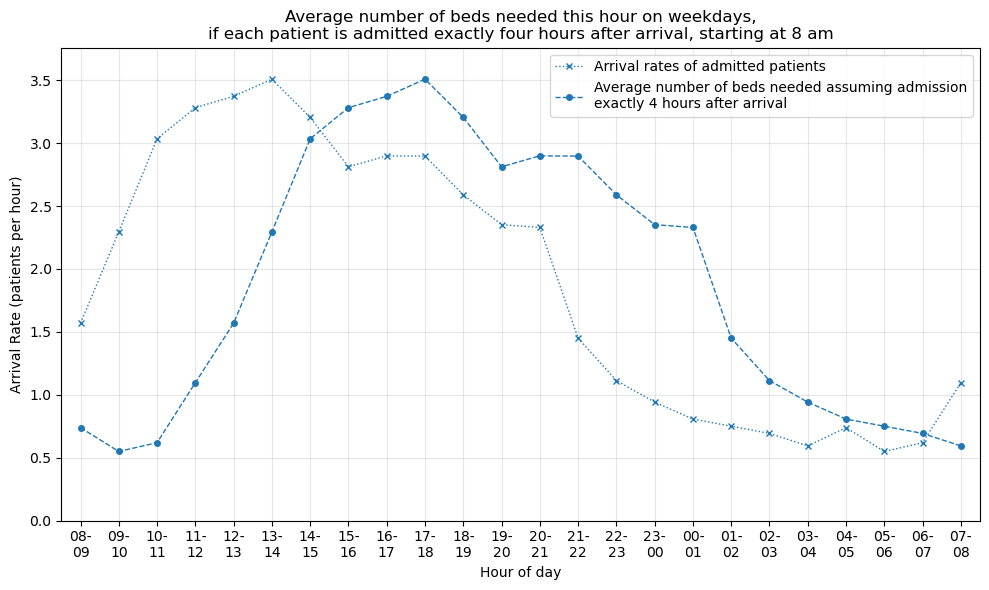

Calculating time-varying arrival rates for data provided, which spans 216 unique dates
Calculating time-varying arrival rates for data provided, which spans 216 unique dates


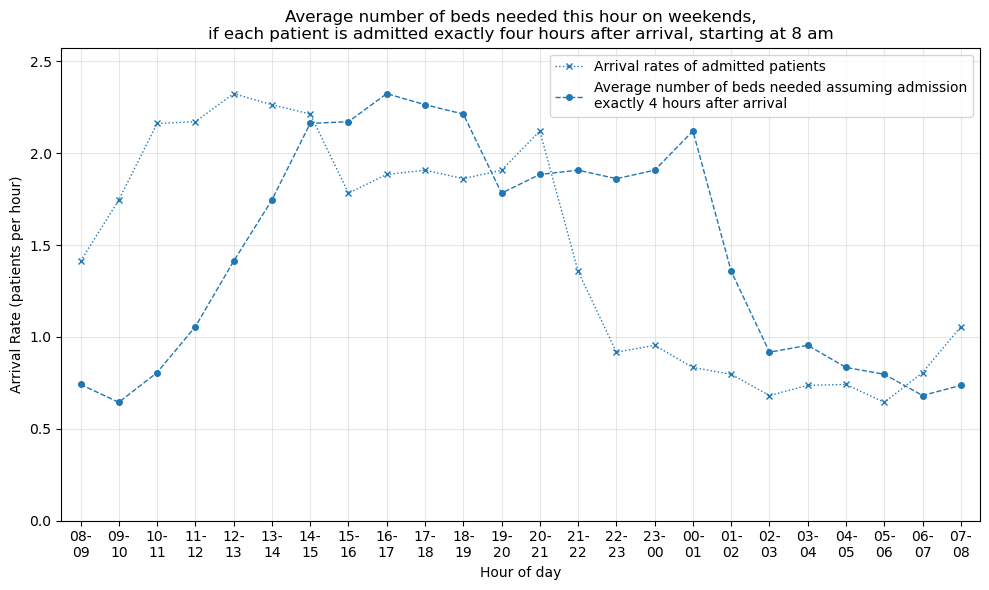

In [50]:
title = 'Average number of beds needed this hour on weekdays,\nif each patient is admitted exactly four hours after arrival, starting at 8 am'
plot_arrival_rates(weekdays,
                   title, 
                   time_interval=60, 
                   start_plot_index=start_plot_index, 
                   file_prefix = '2_', 
                   lagged_by=4,
                    media_file_path=media_file_path_weekdays
)

title = 'Average number of beds needed this hour on weekends,\nif each patient is admitted exactly four hours after arrival, starting at 8 am'
plot_arrival_rates(weekends,
                   title, 
                   time_interval=60, 
                   start_plot_index=start_plot_index, 
                   file_prefix = '2_', 
                   lagged_by=4,
                    media_file_path=media_file_path_weekends
)

## Plot cumulative arrival rates

We can show the same information as above, counting the beds needed cumulatively over the day.   

Calculating time-varying arrival rates for data provided, which spans 543 unique dates


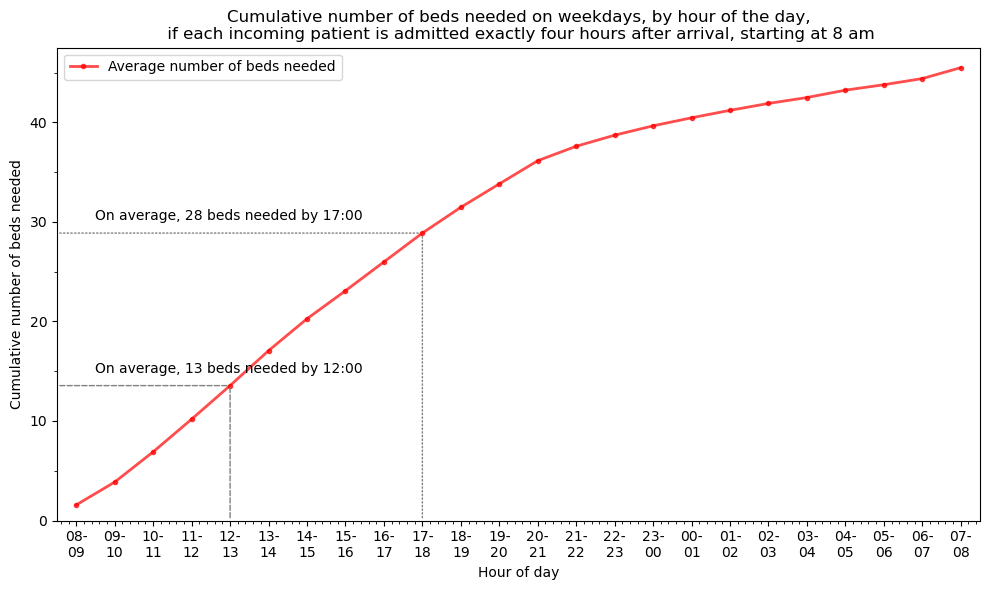

In [51]:
title = f'Cumulative number of beds needed on weekdays, by hour of the day,\n if each incoming patient is admitted exactly four hours after arrival, starting at 8 am'
plot_cumulative_arrival_rates(
    weekdays,
    title,
    start_plot_index=8,
    media_file_path=media_file_path_weekdays,
    file_prefix='3_'
)

## Now considering the influencable window

Here we are interested in bringing forward the number of beds vacated at each hour, such that the necessary number of beds are vacated within the influenceable window before decision-makers leave the wards

We first define a dictionary of scenarios we'd like to plot. (This is simply to reduce lines of code.)

In [52]:
scenarios = [
    {
        'data': weekdays,
        'file_path': media_file_path_weekdays,
        'label': 'weekdays'
    },
    {
        'data': weekends,
        'file_path': media_file_path_weekends,
        'label': 'weekends'
    }
]



Calculating time-varying arrival rates for data provided, which spans 543 unique dates


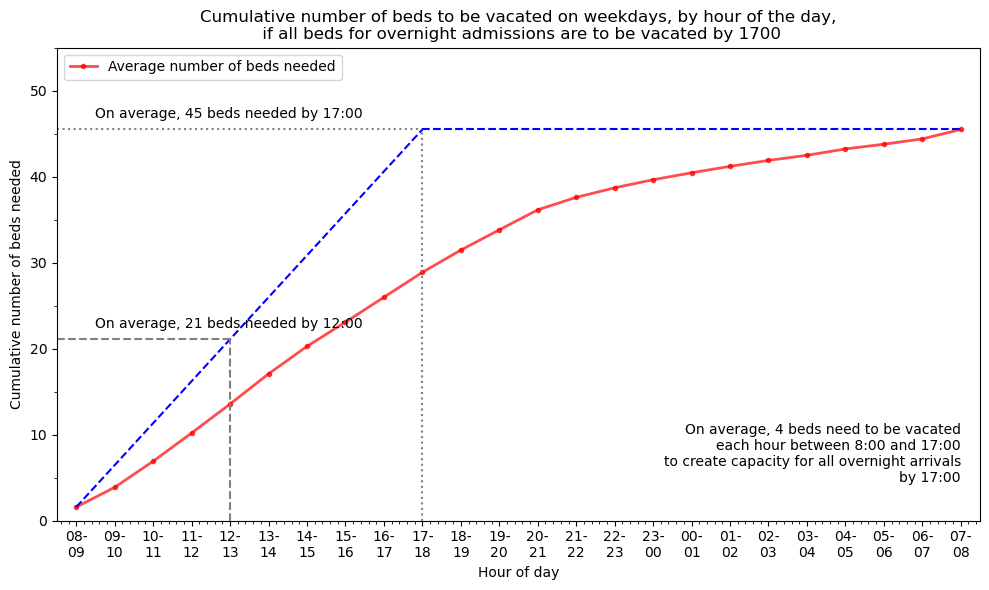

Calculating time-varying arrival rates for data provided, which spans 543 unique dates


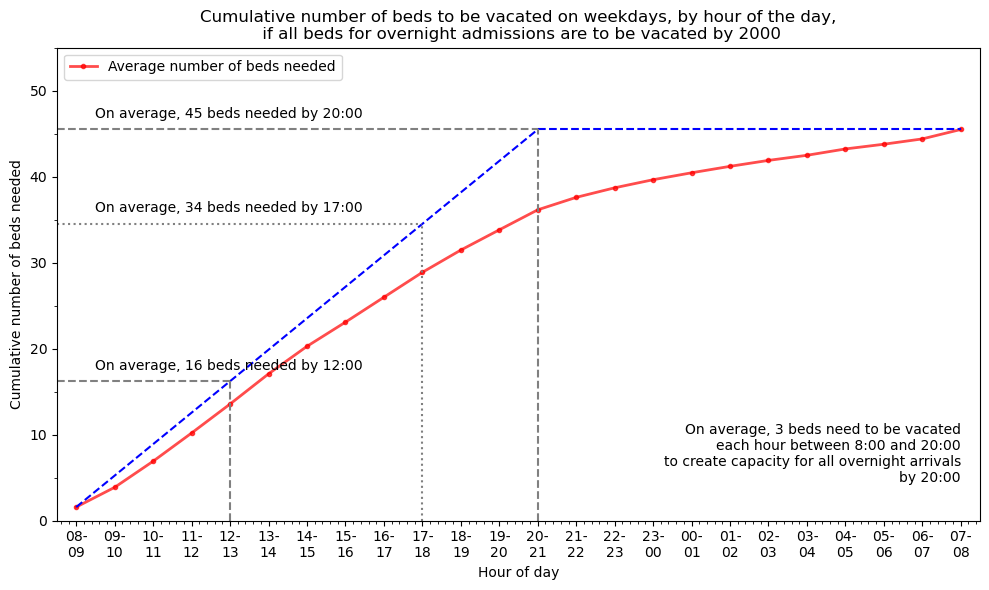

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


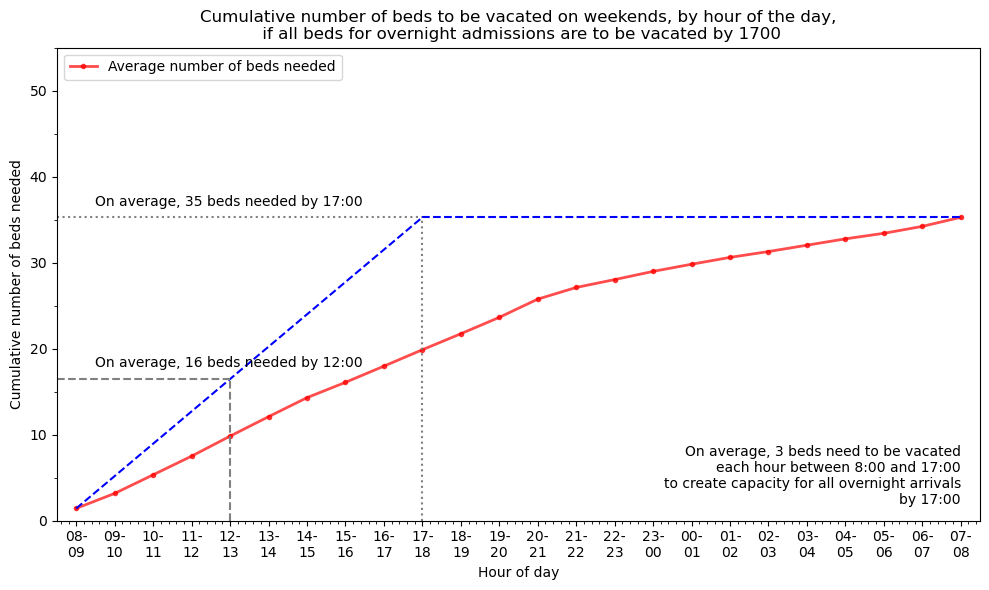

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


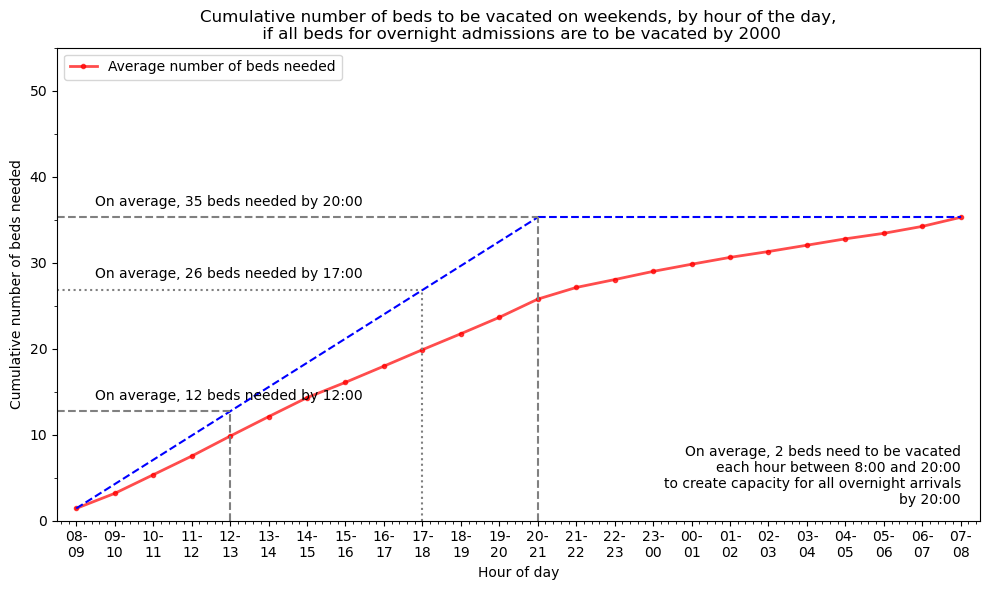

In [53]:
from patientflow.viz.arrival_rates import plot_cumulative_arrival_rates

start_of_influencable_window = 8
end_of_influencable_window = 17


def plot_average_beds_needed(scenarios):
    """
    Generate bed occupancy plots for both weekday and weekend data.
    """
    
    for scenario in scenarios:
        # First plot: 17:00 end of influencable window
        title = f'Cumulative number of beds to be vacated on {scenario["label"]}, by hour of the day,\n if all beds for overnight admissions are to be vacated by {17}00'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            start_plot_index=8,
            draw_window=(start_of_influencable_window, 17),
            media_file_path=scenario["file_path"],
            file_prefix='4_',
            set_y_lim=55
        )
        
        # Second plot: 20:00 end of influencable window
        title = f'Cumulative number of beds to be vacated on {scenario["label"]}, by hour of the day,\n if all beds for overnight admissions are to be vacated by {20}00'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            start_plot_index=8,
            draw_window=(start_of_influencable_window, 20),
            media_file_path=scenario["file_path"],
            file_prefix='4_',
            set_y_lim=55,
            hour_lines=[12,17,20]
        )


plot_average_beds_needed(
    scenarios,
)


## Introducing an aspirational approach

As noted above, this is not very realistic as it assumes that every patient meets the 4-hour target, and that there is no variation in the time it takes people to be processed through ED/SDEC. Ideally patients would be processed sooner than 4 hours in most cases. 

We can instead use a probabilistic approach to determine whether any patient will be admitted within 4 hours. The probability is shown in the plot below.

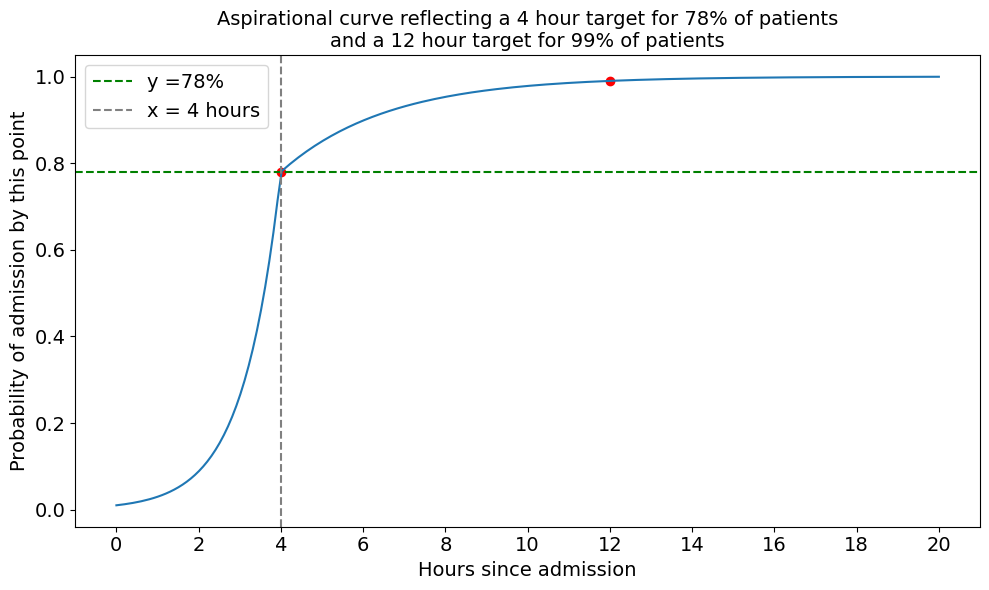

In [54]:
import matplotlib.pyplot as plt
from patientflow.viz.aspirational_curve_plot import plot_curve

figsize = (6,3)
title = 'Aspirational curve reflecting a ' + str(int(x1)) + ' hour target for ' + str(int(y1*100)) + \
        '% of patients\nand a '+ str(int(x2)) + ' hour target for ' + str(int(y2*100)) + '% of patients'

plot_curve(
    title = title,
    x1 = x1,
    y1 = y1,
    x2 = x2,
    y2 = y2,
    figsize = (10,6),
    include_titles=True,
    text_size=14,
    media_file_path=media_file_path_weekends,
    file_name=title.replace(" ", "_"),
)


## Plot the time beds would be needed after applying the aspirational curve

Here, the aspirational curve has been applied. It has the effect of smoothing out the times at which beds are needed (the solid line falls between the time people arrived and the line that is lagged by 4 hours)

Calculating time-varying arrival rates for data provided, which spans 543 unique dates
Calculating time-varying arrival rates for data provided, which spans 543 unique dates
Calculating time-varying arrival rates for data provided, which spans 543 unique dates


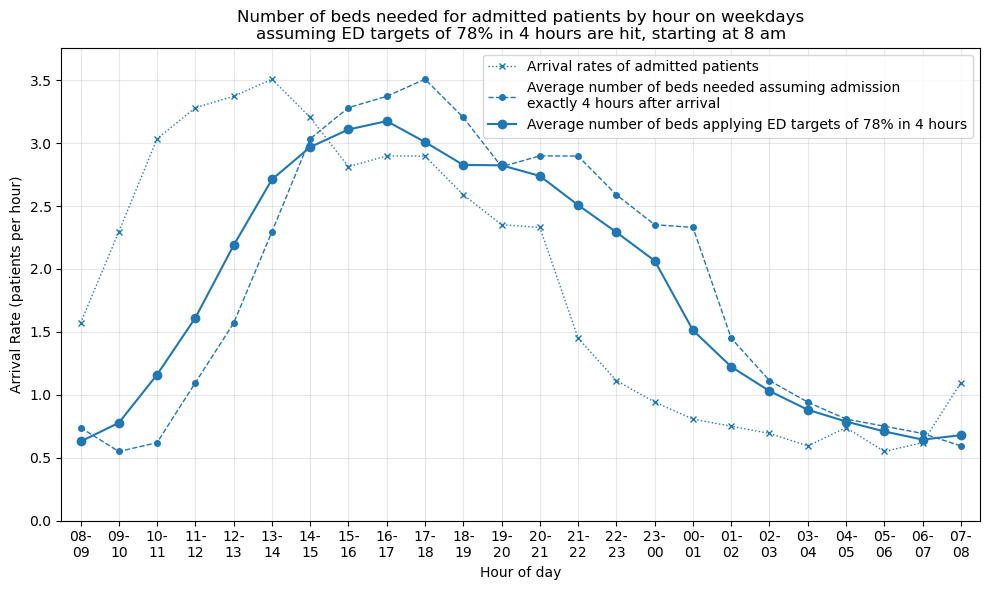

Calculating time-varying arrival rates for data provided, which spans 543 unique dates
Calculating time-varying arrival rates for data provided, which spans 543 unique dates
Calculating time-varying arrival rates for data provided, which spans 216 unique dates
Calculating time-varying arrival rates for data provided, which spans 216 unique dates


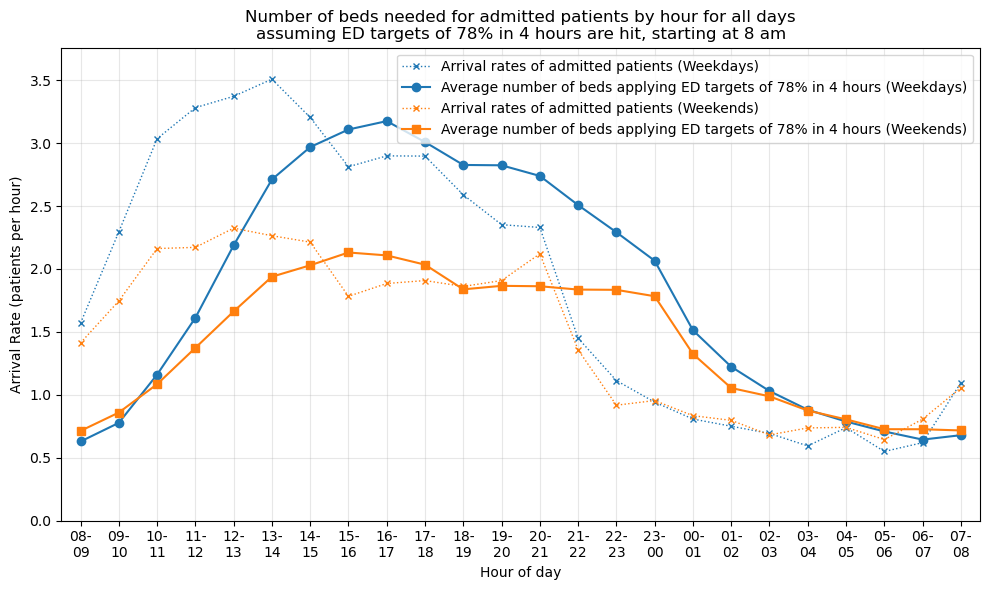

In [55]:

title = f'Number of beds needed for admitted patients by hour on weekdays\nassuming ED targets of {int(y1*100)}% in {int(x1)} hours are hit, starting at 8 am'
plot_arrival_rates(weekdays, title, start_plot_index = 8, 
                   lagged_by=4, 
                   curve_params=(x1, y1, x2, y2), 
                   file_prefix = '5_',
                   media_file_path=media_file_path_weekdays)


# title = f'Number of beds needed for admitted patients by hour on weekends\nassuming ED targets of {int(y1*100)}% in {int(x1)} hours are hit, starting at 8 am'
# plot_arrival_rates(weekends, title, start_plot_index = 8, 
#                    lagged_by=4, 
#                    curve_params=(x1, y1, x2, y2), 
#                    file_prefix = '5_',
#                     media_file_path=media_file_path_weekends)



# plot for both
title = f'Number of beds needed for admitted patients by hour for all days\nassuming ED targets of {int(y1*100)}% in {int(x1)} hours are hit, starting at 8 am'
plot_arrival_rates(inpatient_arrivals=weekdays,
                        inpatient_arrivals_2=weekends, 
                    labels=('Weekdays', 'Weekends'),
                   title=title, 
                   # lagged_by=4, 
                   curve_params=(x1, y1, x2, y2), 
                    start_plot_index=start_plot_index, 
                   file_prefix = '5_',
                   media_file_path=media_file_path_weekends
                   )

We can then plot the cumulative numbers required, applying the aspirational window as before

Calculating time-varying arrival rates for data provided, which spans 543 unique dates


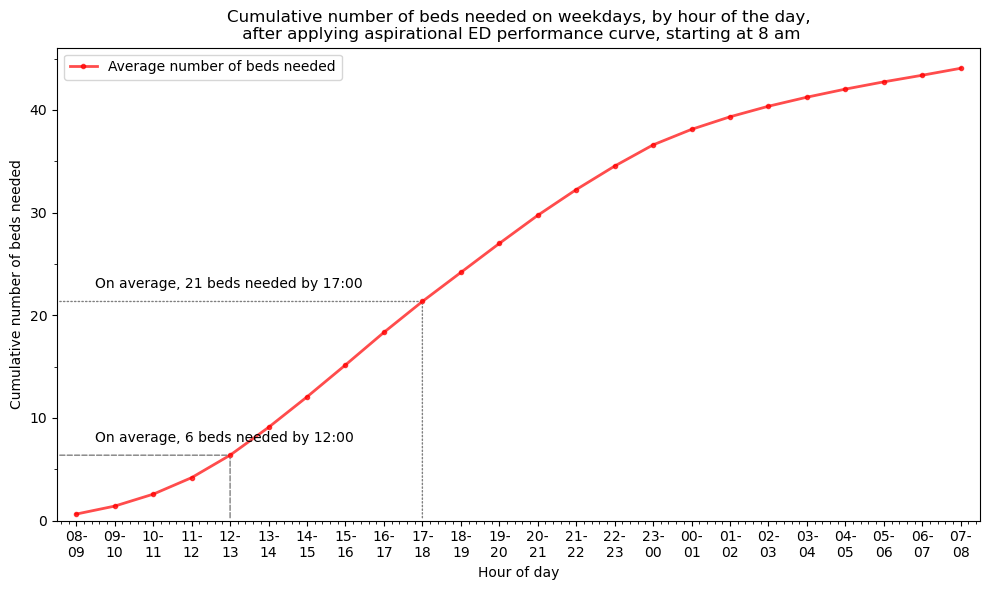

Calculating time-varying arrival rates for data provided, which spans 543 unique dates


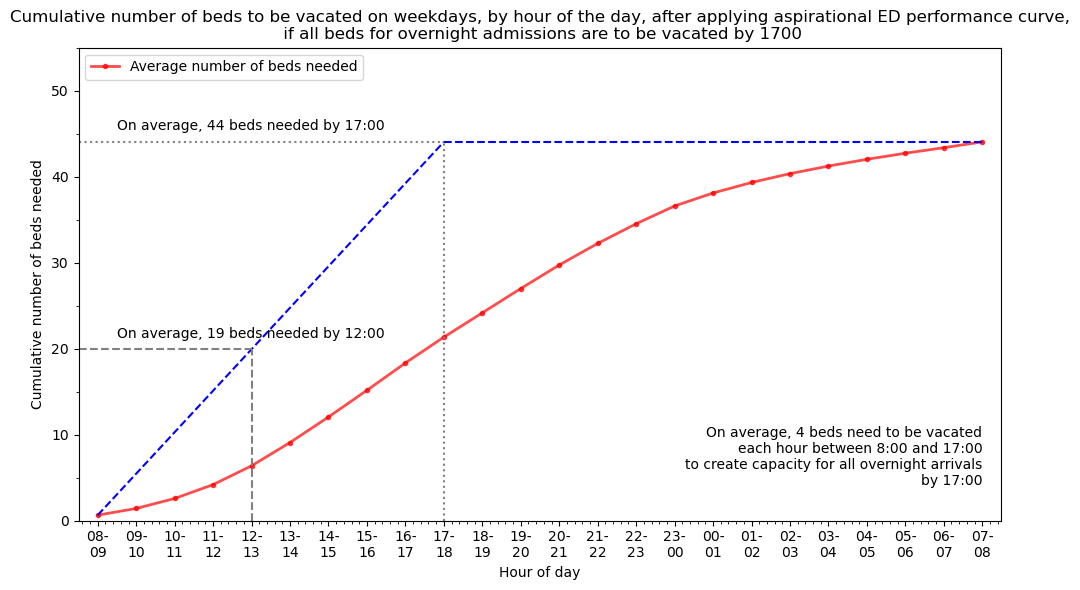

Calculating time-varying arrival rates for data provided, which spans 543 unique dates


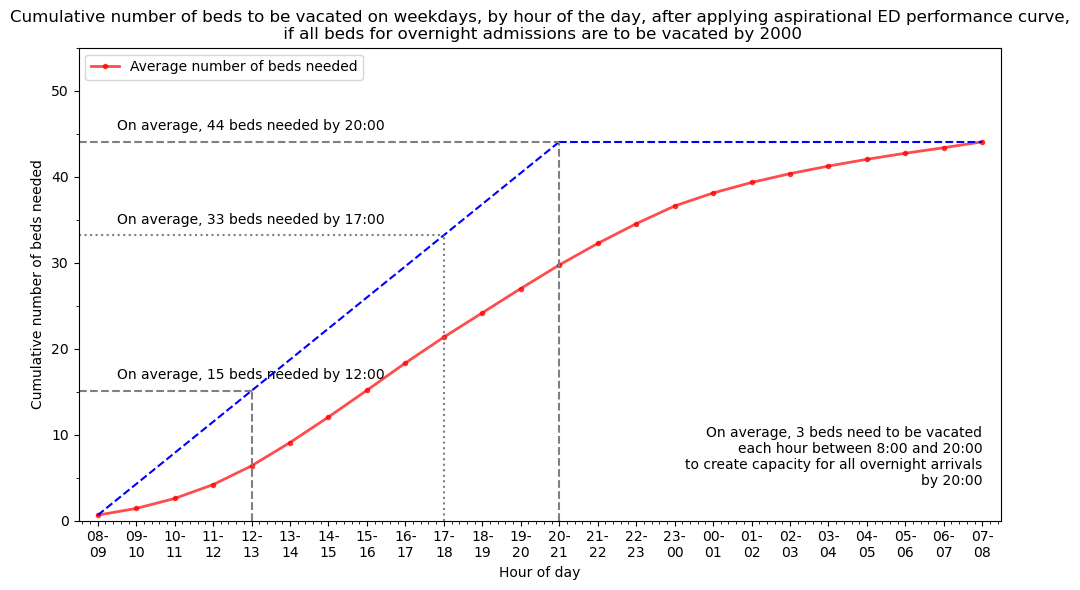

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


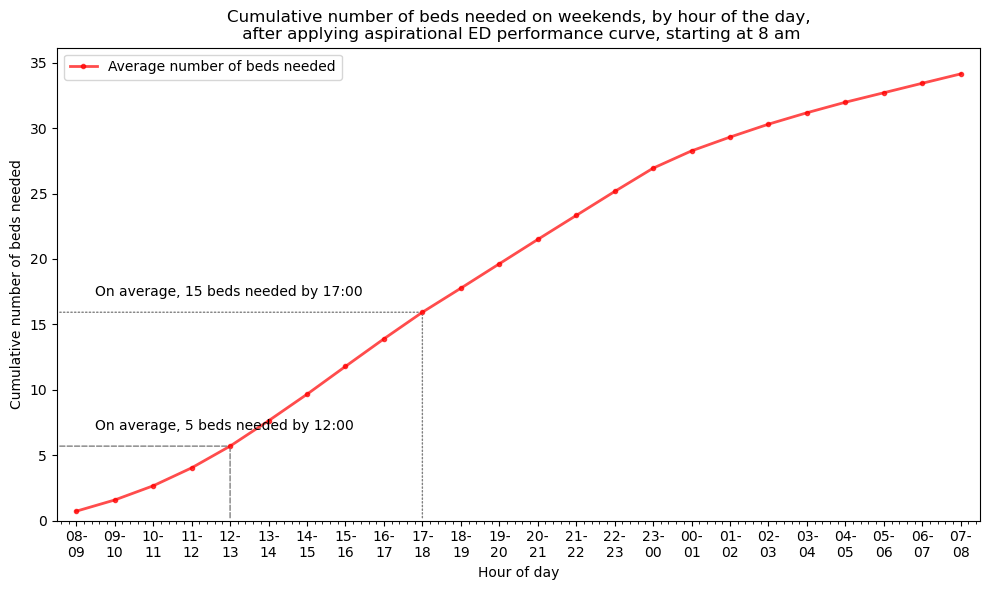

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


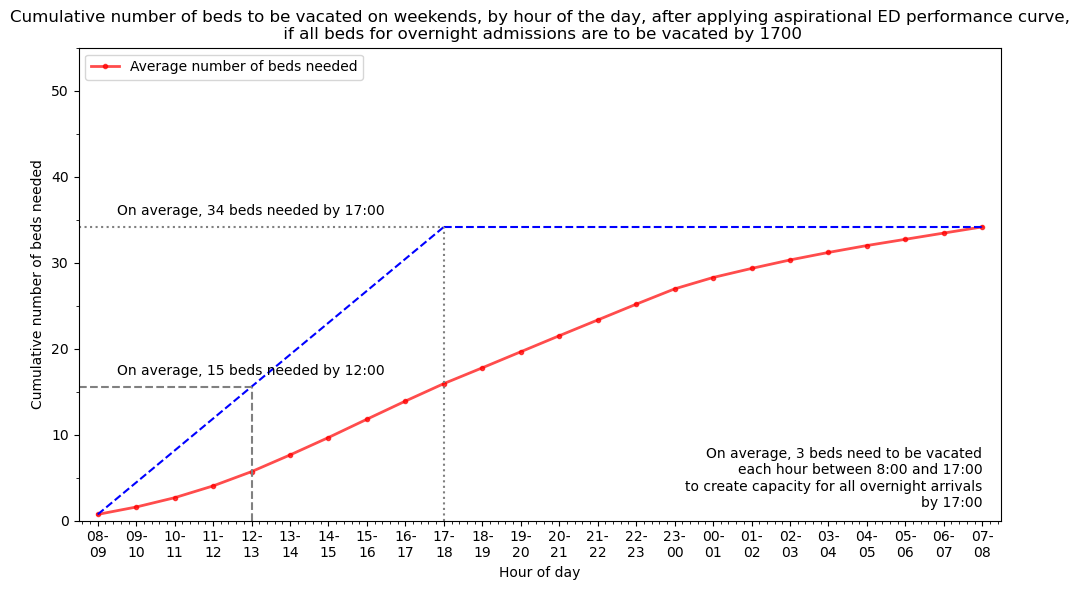

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


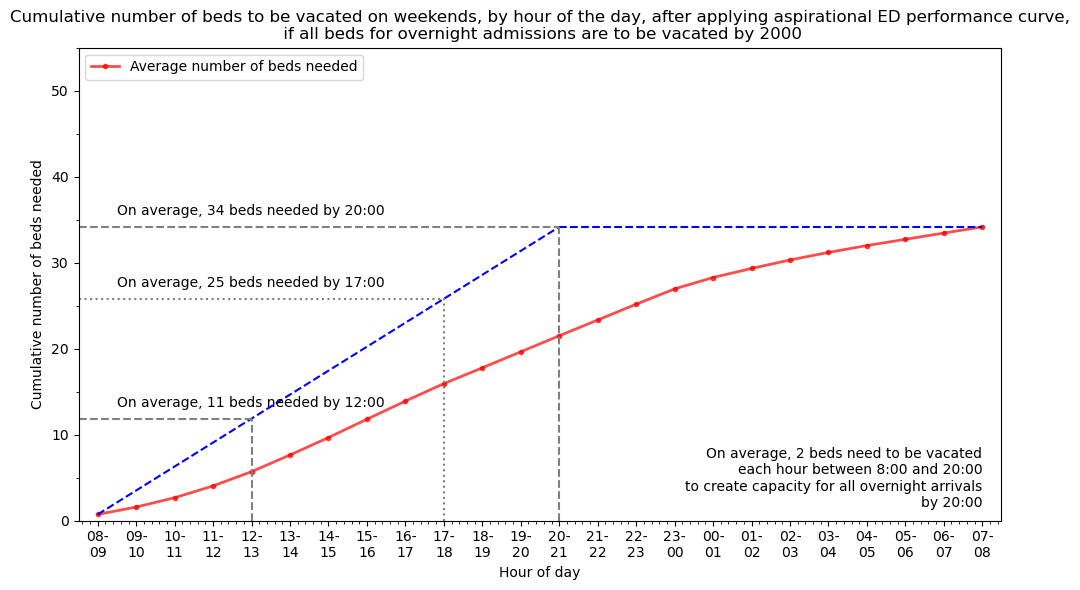

In [56]:
def plot_average_beds_needed_using_aspirational_curve(scenarios):
    """
    Generate bed occupancy plots for both weekday and weekend data, after applying aspirational curve.
    """
    
    for scenario in scenarios:
        # First plot: 4-hour admission delay
        title = f'Cumulative number of beds needed on {scenario["label"]}, by hour of the day,\n after applying aspirational ED performance curve, starting at 8 am'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            curve_params=(x1, y1, x2, y2),
            start_plot_index=8,
            media_file_path=scenario["file_path"],
            file_prefix='6_'
        )
        
        # Second plot: 17:00 vacancy requirement
        title = f'Cumulative number of beds to be vacated on {scenario["label"]}, by hour of the day, after applying aspirational ED performance curve,\n if all beds for overnight admissions are to be vacated by {17}00'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            curve_params=(x1, y1, x2, y2),
            start_plot_index=8,
            draw_window=(start_of_influencable_window, 17),
            media_file_path=scenario["file_path"],
            file_prefix='7_',
            set_y_lim=55
        )
        
        # Second plot: 20:00 vacancy requirement
        title = f'Cumulative number of beds to be vacated on {scenario["label"]}, by hour of the day, after applying aspirational ED performance curve,\n if all beds for overnight admissions are to be vacated by {20}00'
        plot_cumulative_arrival_rates(
            scenario['data'],
            title,
            curve_params=(x1, y1, x2, y2),
            start_plot_index=8,
            draw_window=(start_of_influencable_window, 20),
            media_file_path=scenario["file_path"],
            file_prefix='7_',
            set_y_lim=55,
            hour_lines=[12,17,20]
        )

plot_average_beds_needed_using_aspirational_curve(scenarios)

## Cumulative plot with probabilities

Up to now, we have worked with the average number of beds needed. If this number of beds were ready, the hospital would be equipped to hit its ED targets on a day with average arrival rates, but not on a day that exceeds the average. On such days, the performance against 4-hour targets would deteriorate. 

Here we allow for the idea that a hospital might set an aspiration to hit its ED targets on (say) 90% of days.  

The code below shows how to plot a chart that explores how the number of beds needed by a given hour of the day will change if 4-hour targets are to be met on 90% of days. The red line is the same as above (the  beds that need to be vacated to meet average demand), and the blue dotted line shows the number of empty beds would need to be to ensure that enough capacity is available on 90% of days. 

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


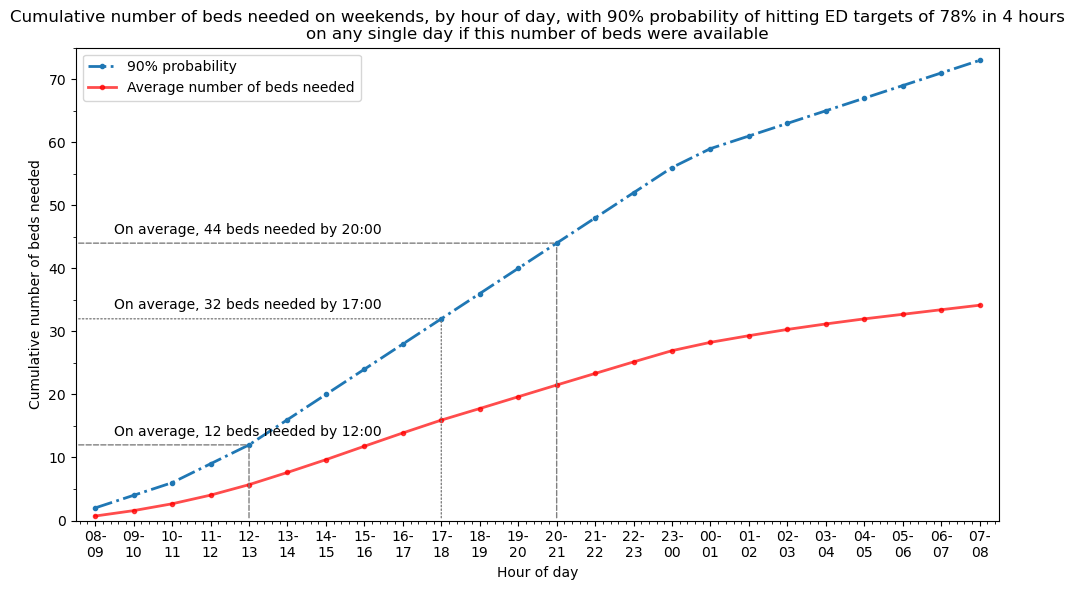

In [69]:


# plot showing just 90% centile for weekends
title = f'Cumulative number of beds needed on weekends, by hour of day, with 90% probability of hitting ED targets of {int(y1*100)}% in {int(x1)} hours\non any single day if this number of beds were available'
plot_cumulative_arrival_rates(
   weekends,
    title,
    curve_params=(x1, y1, x2, y2),
    lagged_by=None,
    time_interval=60,
    start_plot_index=8,
    draw_window=None,
    x_margin=0.5,
    file_prefix='9_',
    set_y_lim=None,
    hour_lines=[12,17,20],
    annotation_prefix='On average',
    line_colour='red',
    plot_centiles=True,
    highlight_centile=0.9,
    centiles=[ 0.9],
    markers=['o'],
    line_styles_centiles=['-.', '--', ':', '-', '-'],
    bed_type_spec='',
    media_file_path=media_file_path_weekends


)

For completeness, we show here how you could plot any number of centiles of probability. 

Calculating time-varying arrival rates for data provided, which spans 543 unique dates


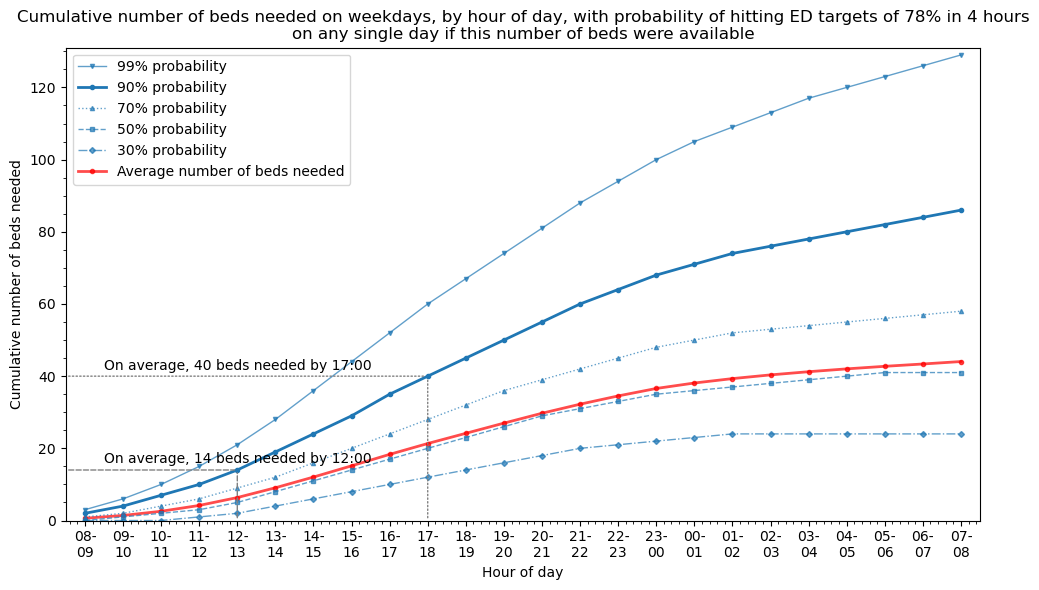

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


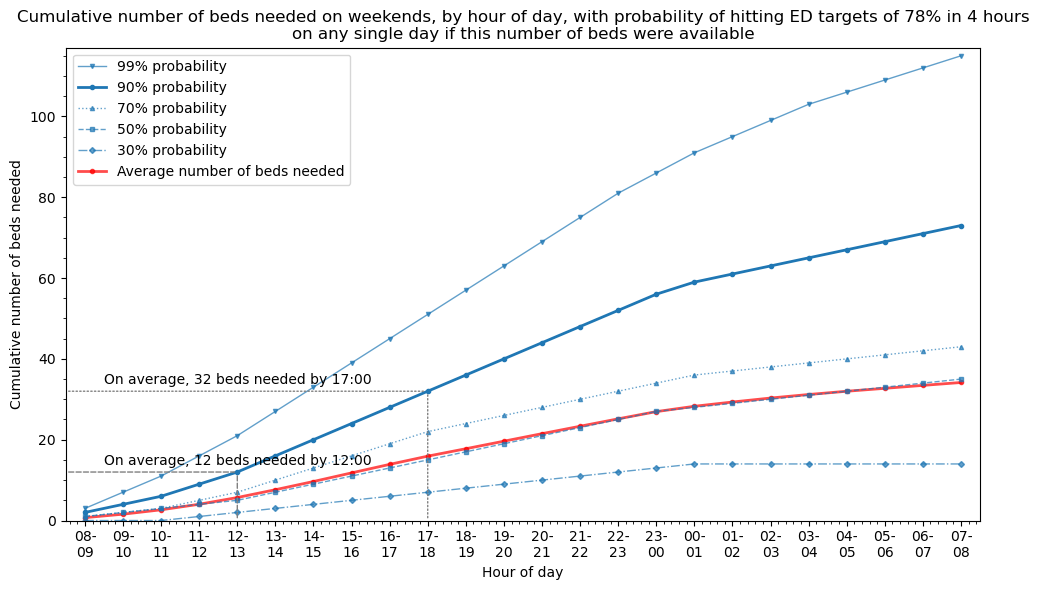

In [70]:
title = f'Cumulative number of beds needed on weekdays, by hour of day, with probability of hitting ED targets of {int(y1*100)}% in {int(x1)} hours\non any single day if this number of beds were available'
plot_cumulative_arrival_rates(
   weekdays,
    title,
    curve_params=(x1, y1, x2, y2),
    lagged_by=None,
    time_interval=60,
    start_plot_index=8,
    draw_window=None,
    x_margin=0.5,
    file_prefix='9_',
    set_y_lim=None,
    hour_lines=[12, 17],
    line_styles={12: '--', 17: ':'},
    annotation_prefix='On average',
    line_colour='red',
    plot_centiles=True,
    highlight_centile=0.9,
    centiles=[0.3, 0.5, 0.7, 0.9, 0.99],
    markers=['D', 's', '^', 'o', 'v'],
    line_styles_centiles=['-.', '--', ':', '-', '-'],
    bed_type_spec='',
    media_file_path=media_file_path_weekdays

)

title = f'Cumulative number of beds needed on weekends, by hour of day, with probability of hitting ED targets of {int(y1*100)}% in {int(x1)} hours\non any single day if this number of beds were available'
plot_cumulative_arrival_rates(
   weekends,
    title,
    curve_params=(x1, y1, x2, y2),
    lagged_by=None,
    time_interval=60,
    start_plot_index=8,
    draw_window=None,
    x_margin=0.5,
    file_prefix='9_',
    set_y_lim=None,
    hour_lines=[12, 17],
    line_styles={12: '--', 17: ':'},
    annotation_prefix='On average',
    line_colour='red',
    plot_centiles=True,
    highlight_centile=0.9,
    centiles=[0.3, 0.5, 0.7, 0.9, 0.99],
    markers=['D', 's', '^', 'o', 'v'],
    line_styles_centiles=['-.', '--', ':', '-', '-'],
    bed_type_spec='',
    media_file_path=media_file_path_weekends


)

## Plot by specialty

Below we show a breakdown by specialty

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


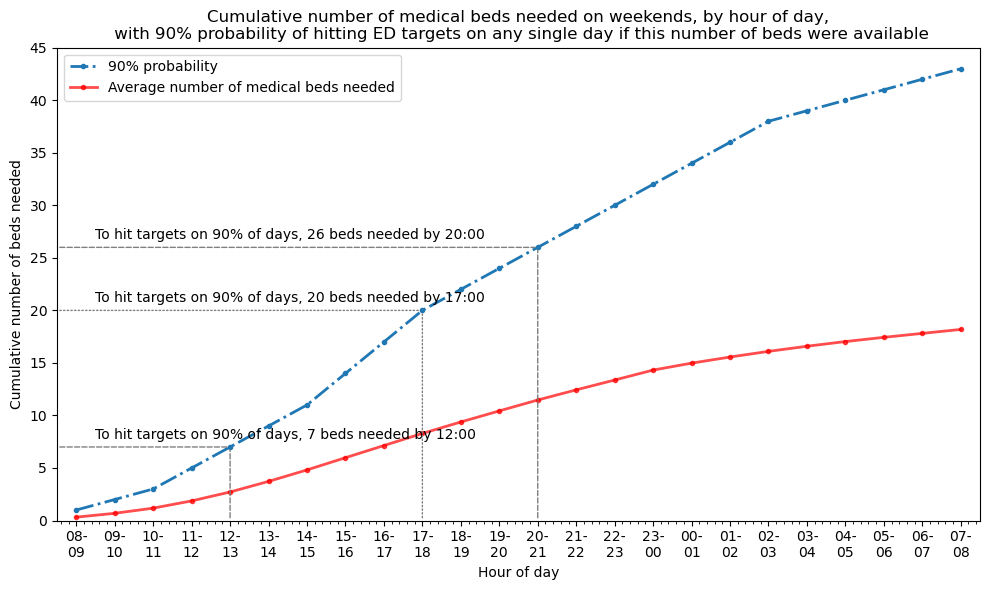

Calculating time-varying arrival rates for data provided, which spans 216 unique dates


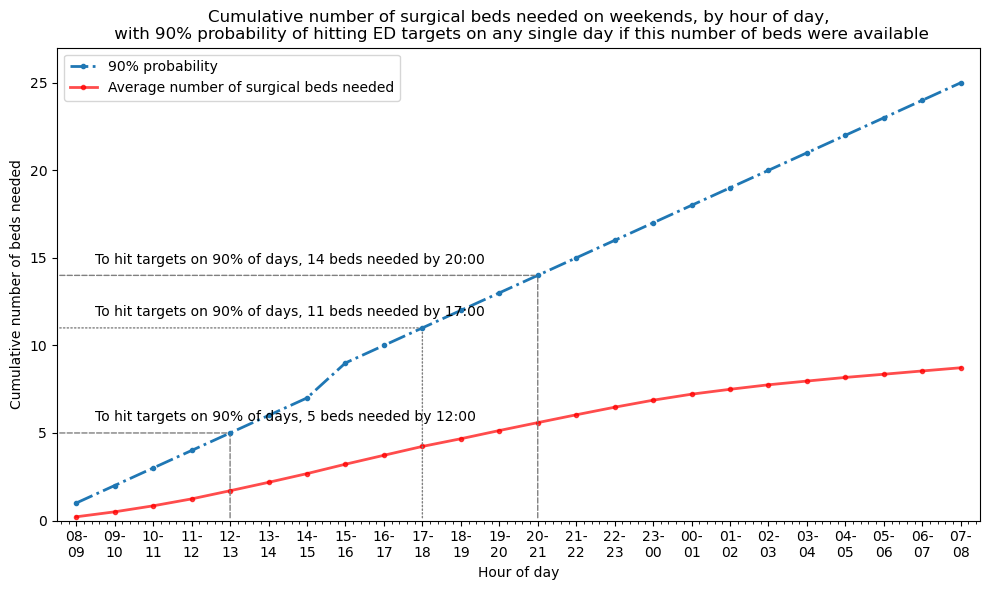

Calculating time-varying arrival rates for data provided, which spans 208 unique dates


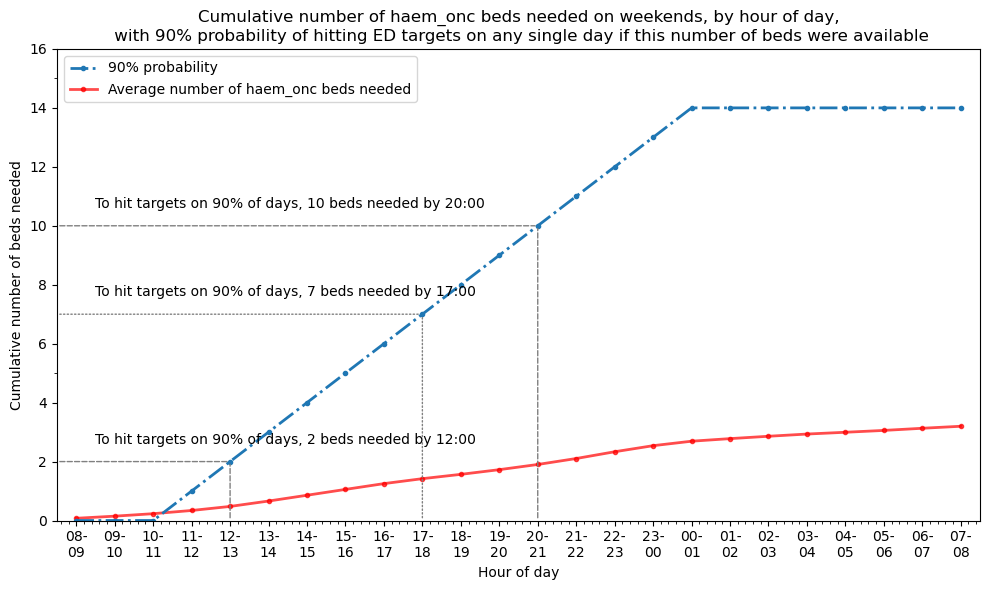

Calculating time-varying arrival rates for data provided, which spans 207 unique dates


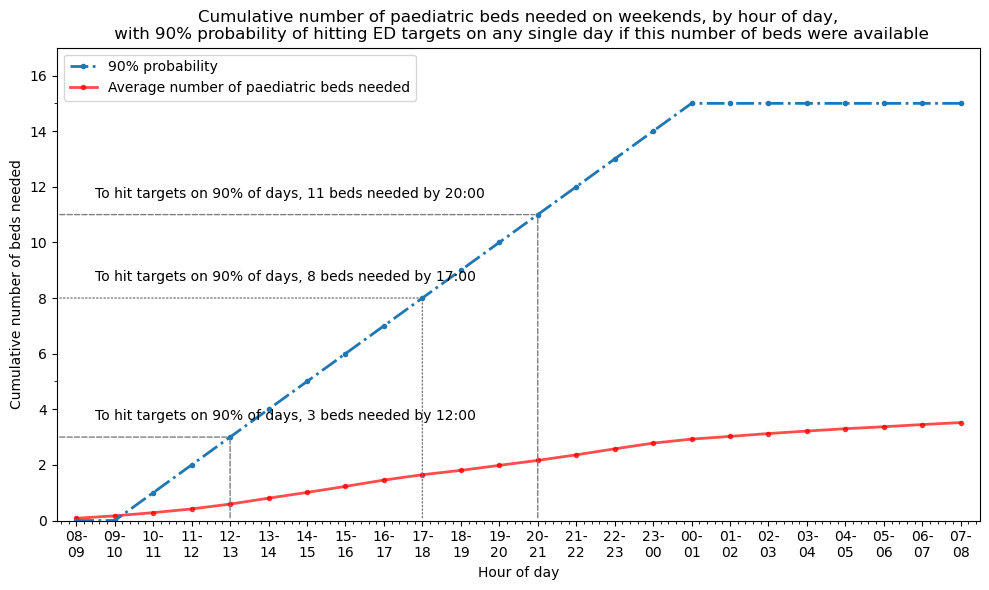

In [71]:
from patientflow.viz.arrival_rates import plot_cumulative_arrival_rates

for _spec in ['medical', 'surgical', 'haem/onc', 'paediatric']:
    inpatient_arrivals_spec = weekends[(~weekends.specialty.isnull()) & (weekends.specialty == _spec)]
    __spec = _spec.replace('/', '_')
    
    title = f'Cumulative number of {__spec} beds needed on weekends, by hour of day,\n with 90% probability of hitting ED targets on any single day if this number of beds were available'

    plot_cumulative_arrival_rates(
    inpatient_arrivals_spec,
        title,
        curve_params=(x1, y1, x2, y2),
        lagged_by=None,
        time_interval=60,
        start_plot_index=8,
        draw_window=None,
        x_margin=0.5,
        file_prefix='A_',
        set_y_lim=None,
        hour_lines=[12,17,20],
        annotation_prefix='To hit targets on 90% of days',
        line_colour='red',
        plot_centiles=True,
        highlight_centile=0.9,
        centiles=[0.9],
        markers=['o'],
        line_styles_centiles=['-.', '--', ':', '-', '-'],
        bed_type_spec=__spec,

        text_y_offset=0.5,
        media_file_path=media_file_path_weekends


    )
    


## Conclusion

The charts above have used in presentations with UCLH's patient flow improvement group, as part of a wider project on Emergency Patient Pathways. They help to focus attention on a very intractable problem. Hospitals are full, most of the time. Beds are vacated at certain times of day, typically afternoons and early evening. People show up at the ED/SDEC all through the day, not just at times that suit the way the hospital works. This makes it very difficult to hit ED targets when hospitals are full, unless proactive steps are taken. 

Note that all the charts have been created using only a very simple set of inputs